['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Using device: cuda
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: 

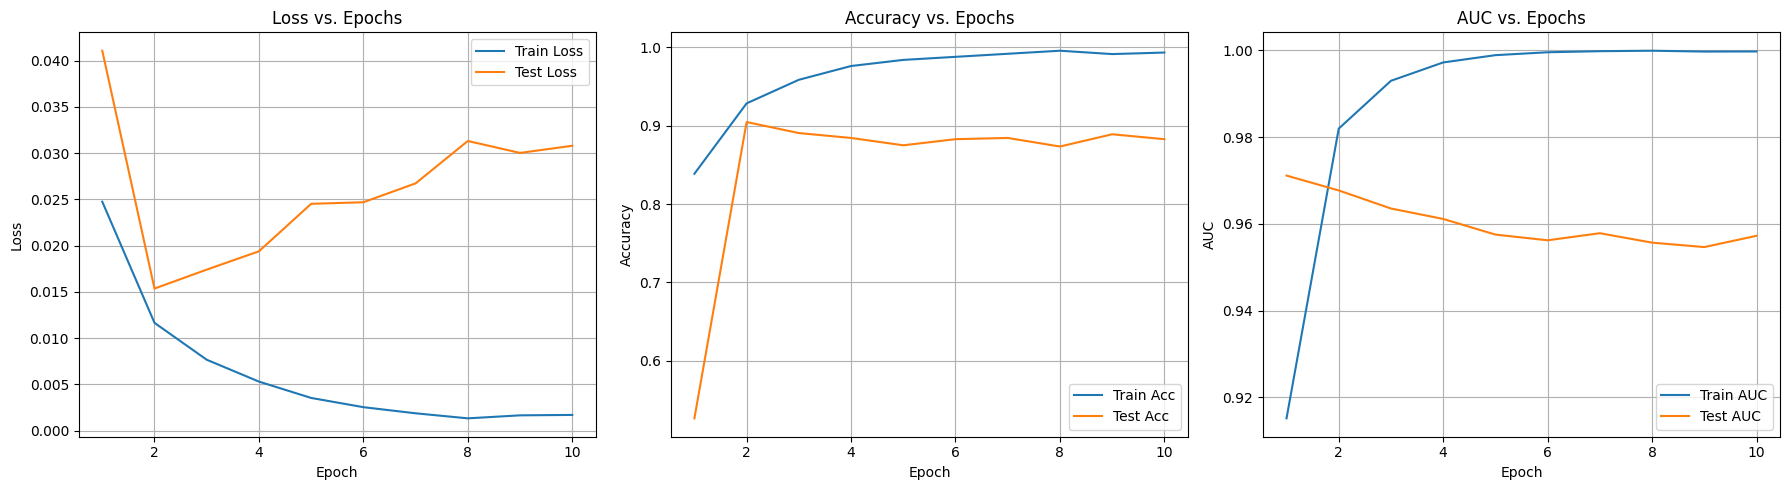

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Install insightface if not installed (>= 0.7+):
# pip install insightface opencv-python

import insightface
from insightface.app import FaceAnalysis
import onnxruntime
print(onnxruntime.get_available_providers())

# --------------------------------------------------
#               DEVICE + CLEAR CACHE
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()
print(f"Using device: {device}")

# --------------------------------------------------
#            DATASET & PATHS
# --------------------------------------------------
base_dir = os.path.join('dataset', 'lfw-deepfunneled', 'lfw-deepfunneled')
pairs_train_path = 'pairsDevTrain.txt'
pairs_test_path = 'pairsDevTest.txt'

def normalize_name(name):
    return name.replace(' ', '_')

def load_pairs(pairs_path, base_dir):
    """
    Parse the LFW pairs file and return a list of (img1_path, img2_path, label).
    label=1 => same person, label=0 => different.
    """
    pairs = []
    with open(pairs_path, 'r') as f:
        lines = f.readlines()[1:]  # skip header
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:  # Positive pair
                person, img1, img2 = parts
                person = normalize_name(person)
                img1_path = os.path.join(base_dir, person, f"{person}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person, f"{person}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 1))
            elif len(parts) == 4:  # Negative pair
                p1, img1, p2, img2 = parts
                p1, p2 = normalize_name(p1), normalize_name(p2)
                img1_path = os.path.join(base_dir, p1, f"{p1}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, p2, f"{p2}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 0))
    return pairs

# Load LFW pairs
train_pairs = load_pairs(pairs_train_path, base_dir)
test_pairs = load_pairs(pairs_test_path, base_dir)
all_pairs = train_pairs + test_pairs

# --------------------------------------------------
#   ARCFACE (R100) VIA INSIGHTFACE "buffalo_l"
# --------------------------------------------------
app = FaceAnalysis(
    name='buffalo_l', 
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
app.prepare(ctx_id=0, det_size=(112,112))  # Assume 112x112

def get_arcface_embedding(img_path):
    bgr_img = cv2.imread(img_path)
    if bgr_img is None:
        raise ValueError(f"Could not load image: {img_path}")
    bgr_img = cv2.resize(bgr_img, (112, 112))
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    recognition_model = app.models['recognition']  # ArcFaceONNX
    feat = recognition_model.get_feat(rgb_img)
    feat_norm = feat / np.linalg.norm(feat)
    return feat_norm.astype(np.float32)

# --------------------------------------------------
#   GENERATE & CACHE EMBEDDINGS
# --------------------------------------------------
def build_embeddings_dict(pairs_list):
    unique_paths = set()
    for (img1, img2, _) in pairs_list:
        unique_paths.add(img1)
        unique_paths.add(img2)
    unique_paths = list(unique_paths)

    emb_dict = {}
    for path in unique_paths:
        emb = get_arcface_embedding(path)  # shape=(512,)
        emb_dict[path] = emb
    return emb_dict

# --------------------------------------------------
#   MLP CLASSIFIER ON abs-diff OF EMBEDDINGS
# --------------------------------------------------
class PairMLP(nn.Module):
    """
    Takes input shape=(N,512) => outputs prob of "same person".
    """
    def __init__(self, input_dim=512, hidden_dims=[256, 128], dropout=0.3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 512)
        return torch.sigmoid(self.net(x))

# --------------------------------------------------
#       FOCAL LOSS (Optional)
# --------------------------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCELoss(reduction='none')

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)
        pt = torch.exp(-bce_loss)
        focal = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal.mean()

# --------------------------------------------------
#   DATASET FOR (abs-diff, label)
# --------------------------------------------------
class DiffLabelDataset(Dataset):
    def __init__(self, pairs_list, emb_dict, decimals=4):
        super().__init__()
        self.samples = []
        self.decimals = decimals
        scale = 10**decimals if decimals else None

        for (img1, img2, lab) in pairs_list:
            emb1 = emb_dict[img1].copy()
            emb2 = emb_dict[img2].copy()
            if scale:
                emb1 = np.floor(emb1 * scale) / scale
                emb2 = np.floor(emb2 * scale) / scale
            diff = np.abs(emb1 - emb2).astype(np.float32)
            self.samples.append((diff, float(lab)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        diff, lab = self.samples[idx]
        return torch.tensor(diff, dtype=torch.float32), torch.tensor(lab, dtype=torch.float32)

# --------------------------------------------------
#        TRAIN MLP ON (diff,label)
# --------------------------------------------------
def train_mlp(
    pair_mlp,
    train_dataset,
    test_dataset,
    epochs=10,
    batch_size=64,
    lr=1e-3,
    alpha=0.25,
    gamma=2.0
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    pair_mlp.to(device)
    optimizer = optim.Adam(pair_mlp.parameters(), lr=lr)
    criterion = FocalLoss(alpha=alpha, gamma=gamma)

    history = {
        'train_loss': [], 'test_loss': [],
        'train_acc': [], 'test_acc': [],
        'train_auc': [], 'test_auc': []
    }

    for epoch in range(epochs):
        # ---------- TRAIN ----------
        pair_mlp.train()
        total_train, correct_train = 0, 0
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        for diffs, labels in train_loader:
            diffs, labels = diffs.to(device), labels.to(device)

            optimizer.zero_grad()
            preds = pair_mlp(diffs)
            loss = criterion(preds, labels.unsqueeze(1))

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            total_train += labels.size(0)

            pred_bin = (preds > 0.5).float().squeeze()
            correct_train += (pred_bin == labels).sum().item()

            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(preds.detach().cpu().numpy().flatten())

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train / total_train
        epoch_auc = roc_auc_score(y_true_train, y_pred_train)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['train_auc'].append(epoch_auc)

        # ---------- EVAL ----------
        pair_mlp.eval()
        total_test, correct_test = 0, 0
        test_loss = 0.0
        y_true_test, y_pred_test = [], []

        with torch.no_grad():
            for diffs, labels in test_loader:
                diffs, labels = diffs.to(device), labels.to(device)
                preds = pair_mlp(diffs)
                loss_val = criterion(preds, labels.unsqueeze(1))

                test_loss += loss_val.item() * labels.size(0)
                total_test += labels.size(0)

                pred_bin = (preds > 0.5).float().squeeze()
                correct_test += (pred_bin == labels).sum().item()

                y_true_test.extend(labels.cpu().numpy())
                y_pred_test.extend(preds.cpu().numpy().flatten())

        epoch_test_loss = test_loss / total_test
        epoch_test_acc = correct_test / total_test
        epoch_test_auc = roc_auc_score(y_true_test, y_pred_test)

        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc)
        history['test_auc'].append(epoch_test_auc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss={epoch_loss:.4f}, Acc={epoch_acc*100:.2f}%, AUC={epoch_auc:.4f} | "
              f"Test Loss={epoch_test_loss:.4f}, Acc={epoch_test_acc*100:.2f}%, AUC={epoch_test_auc:.4f}")

    return history

# --------------------------------------------------
#                 MAIN
# --------------------------------------------------
if __name__ == "__main__":
    X_train_pairs, X_test_pairs = train_test_split(
        all_pairs,
        test_size=0.2,
        stratify=[p[2] for p in all_pairs],
        random_state=42
    )

    print("Building ArcFace embeddings for train set...")
    emb_dict_train = build_embeddings_dict(X_train_pairs)
    print("Building ArcFace embeddings for test set...")
    emb_dict_test = build_embeddings_dict(X_test_pairs)

    DECIMALS = 4
    train_dataset = DiffLabelDataset(X_train_pairs, emb_dict_train, decimals=DECIMALS)
    test_dataset = DiffLabelDataset(X_test_pairs, emb_dict_test, decimals=DECIMALS)

    pair_mlp = PairMLP(input_dim=512, hidden_dims=[256,128], dropout=0.3)

    EPOCHS = 10
    hist = train_mlp(
        pair_mlp,
        train_dataset,
        test_dataset,
        epochs=EPOCHS,
        batch_size=64,
        lr=1e-3,
        alpha=0.25,
        gamma=2.0
    )

    epochs_axis = range(1, EPOCHS+1)
    plt.figure(figsize=(18,5))

    plt.subplot(1,3,1)
    plt.plot(epochs_axis, hist['train_loss'], label='Train Loss')
    plt.plot(epochs_axis, hist['test_loss'], label='Test Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.grid(); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs_axis, hist['train_acc'], label='Train Acc')
    plt.plot(epochs_axis, hist['test_acc'], label='Test Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.grid(); plt.legend()    

    plt.subplot(1,3,3)
    plt.plot(epochs_axis, hist['train_auc'], label='Train AUC')
    plt.plot(epochs_axis, hist['test_auc'], label='Test AUC')
    plt.xlabel('Epoch'); plt.ylabel('AUC')
    plt.title('AUC vs. Epochs')
    plt.grid(); plt.legend()

    plt.tight_layout()
    plt.show()